# DSDP Project

## Objective:
Given is the nutritional value data of the Mcdonalds Menu in the United States.<br>Using the said data the following objectives are to be archived:
1. Identify a business question to be answered:-
    * For new items added to the Menu can we predict the Cholestrol amounts.
    * Given that we know the *List Features here*
2. Identify a target variable to be predicted.
    * Cholestrol content in gms.
2. Identify model to be used for prediction.
    * Linear, Ridge and Lasso is tested.
3. Identify the features to be used to best predict the target variable.
    * Use Filter Feature Selection

### Import and read data

In [68]:
# import all the supporting libaries need to import the data.
import pandas as pd #using pandas as it gives the flexibility of working and altering the data in a data frame

# Read the file into a pandas dataframe
pd.set_option('display.max_columns', 50)
if 'df' in locals():
    del df
#Import and read data
menu_data = pd.read_csv('McDonald_Menu.csv')
#display(menu_data.head())
#display(menu_data.columns)

### Clean Data

#### Shorten Column Names, Remove Spaces and Speacial Caracters

In [70]:
# import all the supporting libaries need to Clean the data.
import re #using regex to be able to remove special characters.

# Remove spaces from the column names
# Find "%_Daily_Value" in column name and repalce it with "PrDV"
# Find "( and )" in column name and remove
# str.replace() is used 
menu_data.columns=menu_data.columns.str.replace(" ", "_") 
menu_data.columns=menu_data.columns.str.replace("%_Daily_Value", "PrDV") 
menu_data.columns=menu_data.columns.str.replace("[()]", "") 

# remove all vowels from column names
vowels=['a','e','i','o','u']
colmap = {}
for col in menu_data.columns:
    col1=col
    for v in vowels:
        col1=col1.replace(v,'')
    colmap[col] = col1
menu_data.columns = list(colmap.values())
#display(menu_data.head())

#### Serving size needs to be split into magnitude and unit columns

In [71]:
# Add Column serving magnitude and unit
menu_data['Srvng_mag'] = 'Unknown'
menu_data['Srvng_unit'] = 'Unknown'

# Function to take the value of Serving Size
# and return the magnitude and unit
def serving_size_parse(ls_seving):
    # Checks for the words "g", "cup", "oz", "carton", "fl"
    # base on the word splits string to give magnitue and unit
    # Returns list of Serving Size row value, magnitue and unit
    mag_unit=[]
    serv_split = ls_seving.split()
    
    if 'g' == serv_split[-1].replace(')',''):
        mag = serv_split[-2].replace('(','')
        unit = serv_split[-1].replace(')','')
    elif 'cup' == serv_split[-1] :
        mag = serv_split[0]
        unit = serv_split[1] + serv_split[2]
    elif 'oz' == serv_split[-1]:
        mag = serv_split[0]
        unit = serv_split[1] + serv_split[2]
    elif 'carton' == serv_split[1]:
        mag = serv_split[-2].replace('(','')
        unit = serv_split[-1].replace(')','')
    elif  'fl' == serv_split[1]:
        mag = serv_split[-2].replace('(','')
        unit = serv_split[-1].replace(')','')
    else:
        mag = ''
        unit = ''
        
    mag_unit.append(ls_seving)
    mag_unit.append(mag)
    mag_unit.append(unit)
    return mag_unit

# Use apply() function on the dataframe
# Reference https://www.youtube.com/watch?v=eMOA1pPVUc4 [39:01]
# Populate the magnitude and unit using apply
menu_data['Srvng_mag'] = menu_data['Srvng_Sz'].apply(lambda x: serving_size_parse(x)[1])
menu_data['Srvng_unit'] = menu_data['Srvng_Sz'].apply(lambda x: serving_size_parse(x)[2])
menu_data['Srvng_mag'] = menu_data['Srvng_mag'].apply(lambda x: float(x))

#Change mg to g
menu_data['Chlstrl']=menu_data['Chlstrl'].apply(lambda x: float(x)/1000)
menu_data['Sdm']=menu_data['Sdm'].apply(lambda x: float(x)/1000)

#Change floz to ml
menu_data.loc[menu_data['Srvng_unit']=='floz','Srvng_mag'] = menu_data['Srvng_mag'].apply(lambda x: float(x)*29.574)
menu_data.loc[menu_data['Srvng_unit']=='floz','Srvng_unit'] = 'ml'

#display(menu_data.head())

#### Drop Serving Size and Item and all Daily value columns

In [73]:
menu_data = menu_data.drop(labels=['Srvng_Sz','Itm'], axis=1)
menu_data = menu_data.drop(labels=[col for col in menu_data.columns if 'PrDV' in col], axis=1)

#### Check for Missing values

In [77]:
#Check for NaN and Null-No Missing Values Found
menu_data.isnull().sum()

Ctgry          0
Clrs           0
Clrs_frm_Ft    0
Ttl_Ft         0
Strtd_Ft       0
Trns_Ft        0
Chlstrl        0
Sdm            0
Crbhydrts      0
Dtry_Fbr       0
Sgrs           0
Prtn           0
Srvng_mag      0
Srvng_unit     0
dtype: int64

#### Add Dummy Columns for Category and Unit

In [79]:
menu_data = pd.get_dummies(menu_data, columns = ['Ctgry','Srvng_unit'],drop_first=True)

### Split data into train and test

In [231]:
# Imported to split data into train and test
from sklearn.model_selection import train_test_split

# Split data into train and test
menu_data_train, menu_data_test = train_test_split( menu_data, train_size = .7,random_state = 99)

# Split data into X_train, X_test and y_train and y_test
X_train = menu_data_train.drop(labels=['Chlstrl'], axis=1)
X_test = menu_data_test.drop(labels=['Chlstrl'], axis=1)

y_train = menu_data_train.Chlstrl
y_test = menu_data_test.Chlstrl

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((182, 20), (182,), (78, 20), (78,))

### Check Linear Regression Model to use

#### Import the Models to Use

In [225]:
# Imported to split data into train and test
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score

models=[]
lr = LinearRegression(normalize=True)
models.append(lr)
rr = Ridge(normalize=True)
models.append(rr)
lar = Lasso(normalize=True)
models.append(lar)

#### Test individual Models
##### Only Ridge Reggression with an alpa value of 1 for regularizarion seems to have some potiential for predicting cholestrol

In [226]:
for model in models:
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring='r2')
    model_name = type(model).__name__
    print(f'Name model: {model_name} , r2 Mean score: {scores.mean()}')

Name model: LinearRegression , r2 Mean score: 0.1652093024650457
Name model: Ridge , r2 Mean score: 0.362439660395494
Name model: Lasso , r2 Mean score: -0.02619218270844974


#### Feature selection using Filter method
##### Check for Constants,Quasi-Constants and duplicates

In [239]:
# Import needed libaries
from sklearn.feature_selection import VarianceThreshold

constant_filter = VarianceThreshold(threshold=0)
constant_filter.fit(X_train)
constant_filter.get_support().sum()
constant_list = [not bol for bol in constant_filter.get_support()]
constant_list
#No Constant Features Found


[False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False]

In [241]:
quasi_constant_filter = VarianceThreshold(threshold=0.01)
quasi_constant_filter.fit(X_train)
quasi_constant_filter.get_support().sum()
quasi_constant_filter = [not bol for bol in constant_filter.get_support()]
quasi_constant_filter
#No Quasi Constant Features Found

[False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False]

In [242]:
X_train_T = X_train.T
X_test_T = X_test.T

In [243]:
X_train_T = pd.DataFrame(X_train_T)
X_test_T = pd.DataFrame(X_test_T)

In [244]:
X_train_T.shape , X_test_T.shape

((20, 182), (20, 78))

In [245]:
X_train_T.duplicated().sum()
#No Duplicates found.

0

##### Check for features which are highly Correlated with Target

In [256]:
train_data = pd.concat([X_train,y_train], axis=1)
train_data
corrmat = train_data.corr()

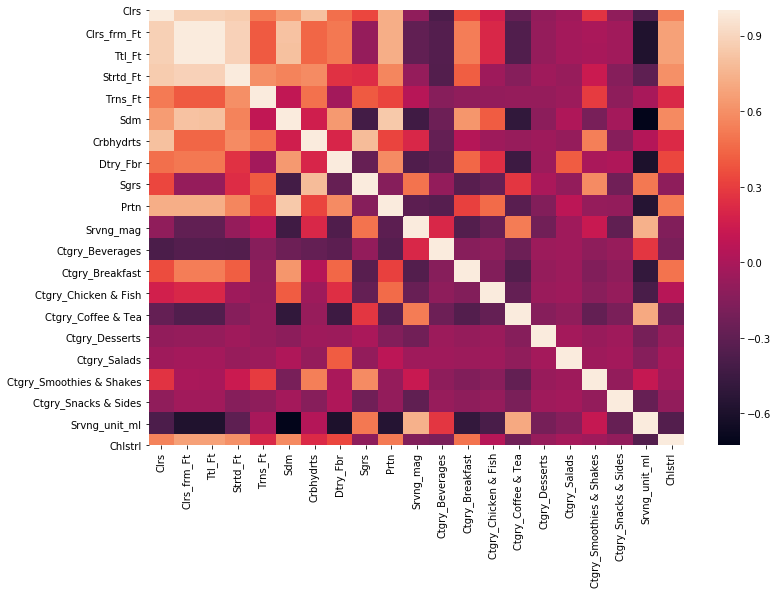

In [257]:
import matplotlib.pyplot as plt #used for graphing and ploting
import seaborn as sns #used for graphing and ploting

plt.figure(figsize=(12,8))
sns.heatmap(corrmat)

In [283]:
#Correlation with output variable
target = 'Chlstrl'
cor_target = abs(corrmat[target])
relevant_features = cor_target[cor_target>0.5]
relevant_features = np.array(relevant_features.index)
relevant_features.remove(target)
relevant_features

['Clrs', 'Clrs_frm_Ft', 'Ttl_Ft', 'Strtd_Ft', 'Sdm', 'Prtn']

In [286]:
# Create Data set only with the highly correlated Features
X_train_corr = X_train[relevant_features]
X_test_corr = X_test[relevant_features]

In [289]:
# Test the ridge Model with the new features
scores = cross_val_score(rr, X_train_corr, y_train, cv=5, scoring='r2')
model_name = type(rr).__name__
print(f'Name model: {model_name} , r2 Mean score: {scores.mean()}')

Name model: Ridge , r2 Mean score: 0.35817784035066574


#### Check and remove any inter correlated Features

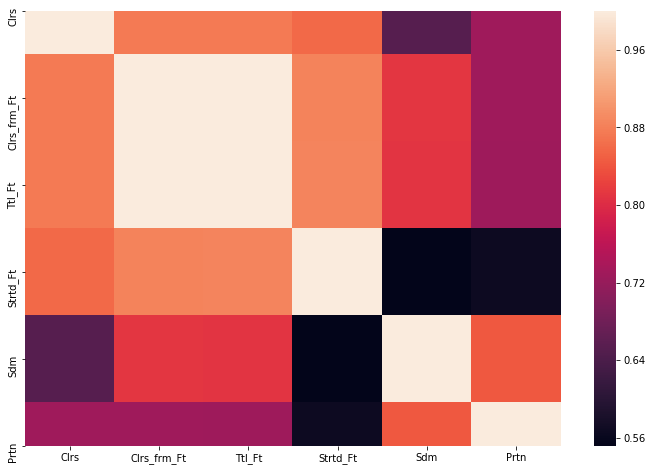

In [292]:
corrmat = X_train_corr.corr()
plt.figure(figsize=(12,8))
sns.heatmap(corrmat)
plt.show()

In [293]:
def get_correlation(data, threshold):
    corr_col = set()
    corrmat = data.corr()
    for i in range(len(corrmat.columns)):
        for j in range(i):
            if abs(corrmat.iloc[i, j]) > threshold:
                colname = corrmat.columns[i]
                corr_col.add(colname)
    return corr_col

In [296]:
corr_features = get_correlation(X_train_corr,0.85)
corr_features

{'Clrs_frm_Ft', 'Strtd_Ft', 'Ttl_Ft'}